In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load data
df = pd.read_csv('/kaggle/input/solargeneration/dataset.csv')
df['date_time'] = pd.to_datetime(df['date_time'], format='%d-%m-%Y %H:%M')

In [2]:
# Feature engineering
df['hour'] = df['date_time'].dt.hour
df['day_of_week'] = df['date_time'].dt.dayofweek

# Select features and target
features = ['temperature', 'Ground_radiation_intensity ', 'hour']
X = df[features]
y = df['Photovoltaic_power_generation']
# Split data (time-series split)
train_size = int(len(X) * 0.8)
X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]

In [3]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score,mean_absolute_error
from sklearn.model_selection import cross_val_score, KFold
from sklearn.model_selection import GridSearchCV

# Initialize scaler
scaler = StandardScaler()

# Fit on training data only (avoid data leakage)
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)  # Use same scaler

# Convert back to DataFrame for readability
X_train = pd.DataFrame(X_train_scaled, columns=features, index=X_train.index)
X_test = pd.DataFrame(X_test_scaled, columns=features, index=X_test.index)

Support Vector Regressor without hyperparameter tuning


Default SVR Test Set Evaluation:
MSE: 828570.36
RMSE: 910.26
MAE: 530.47
R² Score: 0.35


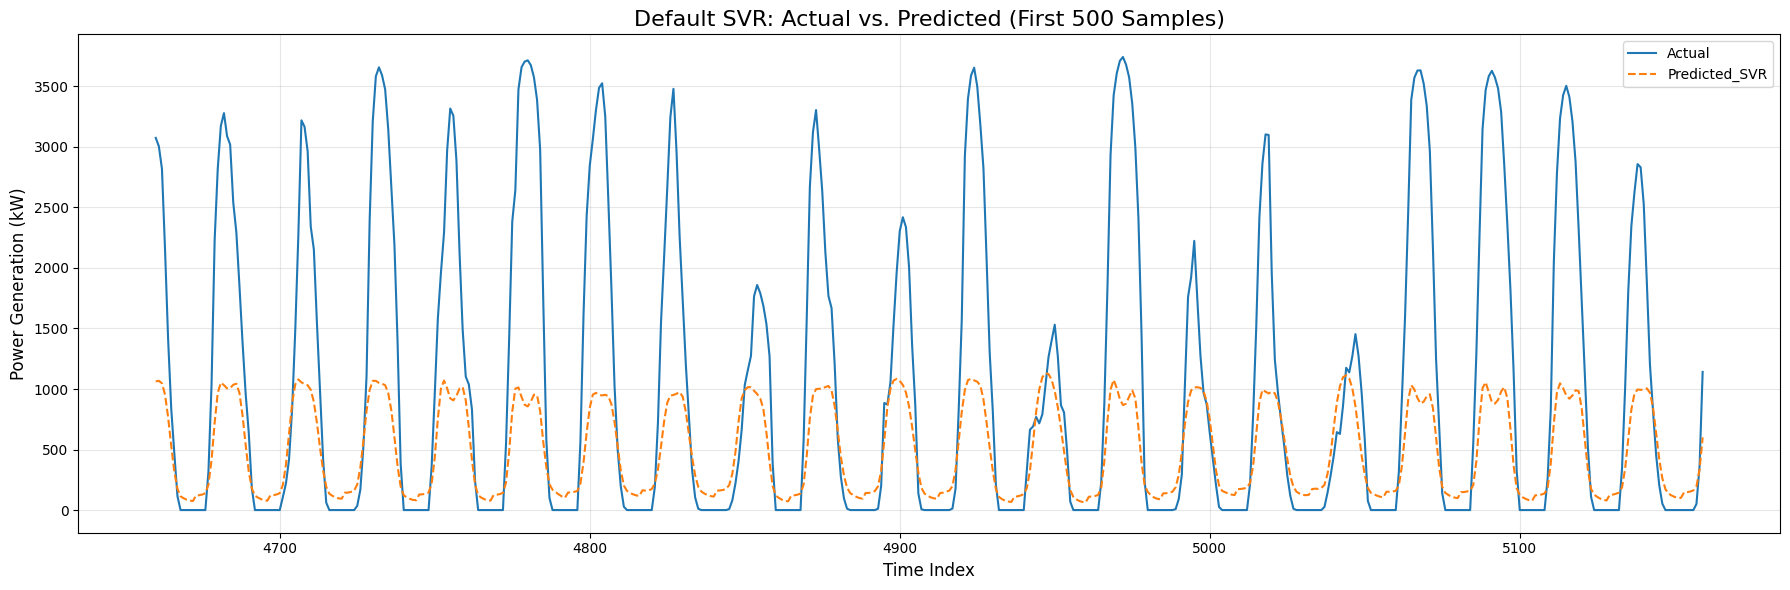

In [4]:
# Initialize SVR with default parameters 
svr = SVR(kernel='rbf', C=1.0, epsilon=0.01)

# Fit on training data
svr.fit(X_train, y_train)

# Predict on test set
y_pred_svr = svr.predict(X_test)

# Evaluate predictions
mse = mean_squared_error(y_test, y_pred_svr)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred_svr)
r2 = r2_score(y_test, y_pred_svr)

print(f"\nDefault SVR Test Set Evaluation:")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R² Score: {r2:.2f}")

# Visualization
results_svr = pd.DataFrame({
    'Actual': y_test,
    'Predicted_SVR': y_pred_svr
}, index=y_test.index)

plt.figure(figsize=(18, 6))
results_svr.head(500).plot(style=['-', '--'], ax=plt.gca())
plt.title("Default SVR: Actual vs. Predicted (First 500 Samples)", fontsize=16)
plt.xlabel("Time Index", fontsize=12)
plt.ylabel("Power Generation (kW)", fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


Support Vector Regressor with Hyperparameter Tuning

In [6]:
# Define parameter grid for tuning
param_grid = {
    'kernel': ['rbf', 'linear', 'poly'],
    'C': [0.1, 1, 10, 100],
    'epsilon': [0.01, 0.1, 0.2, 0.5]
}

# Setup GridSearchCV
grid_search = GridSearchCV(svr, param_grid, cv=10, scoring='r2', n_jobs=-1, verbose=0)
# Fit on training data
grid_search.fit(X_train, y_train)

# Best estimator and parameters
print("Best parameters found by GridSearchCV:", grid_search.best_params_)
best_svr = grid_search.best_estimator_


Best parameters found by GridSearchCV: {'C': 100, 'epsilon': 0.5, 'kernel': 'rbf'}


In [7]:
# Predict on test set using best model
y_pred_best_svr = best_svr.predict(X_test)

cv = KFold(n_splits=5, shuffle=True, random_state=42)
cv_r2_scores = cross_val_score(best_svr, X_train, y_train, cv=cv, scoring='r2')

print("\n📉 Cross-Validation R² Scores on Training Data:")
for i, score in enumerate(cv_r2_scores, 1):
    print(f"Fold {i}: {score:.4f}")
print(f"\n✅ Mean CV R²: {cv_r2_scores.mean():.4f} ± {cv_r2_scores.std():.4f}")

# Evaluate predictions
mse = mean_squared_error(y_test, y_pred_best_svr)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred_best_svr)
r2 = r2_score(y_test, y_pred_best_svr)

print(f"\nTuned SVR Test Set Evaluation:")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R² Score: {r2:.2f}")


📉 Cross-Validation R² Scores on Training Data:
Fold 1: 0.8558
Fold 2: 0.8457
Fold 3: 0.8654
Fold 4: 0.8121
Fold 5: 0.8323

✅ Mean CV R²: 0.8423 ± 0.0186

Tuned SVR Test Set Evaluation:
MSE: 208397.21
RMSE: 456.51
MAE: 269.55
R² Score: 0.84


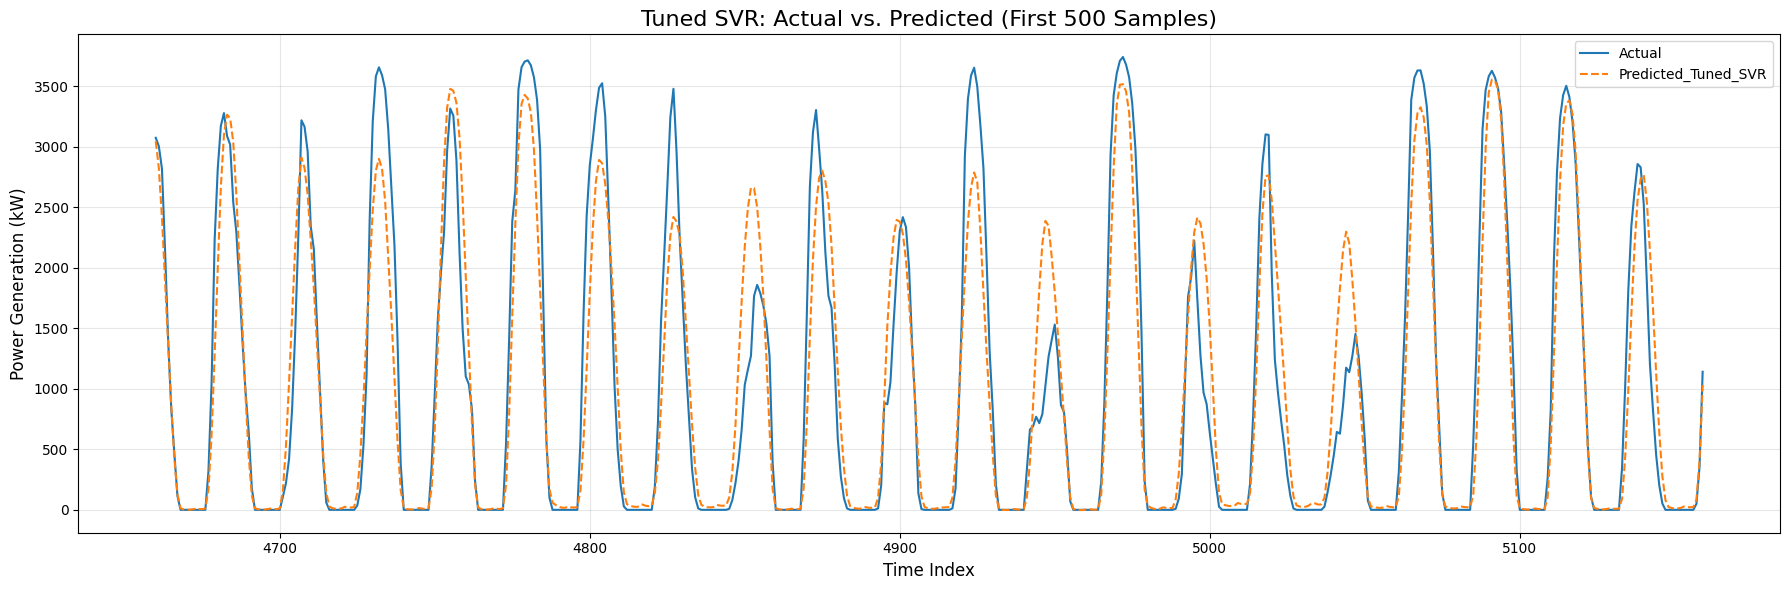

In [8]:
# Visualization
import matplotlib.pyplot as plt
results_tuned_svr = pd.DataFrame({
    'Actual': y_test,
    'Predicted_Tuned_SVR': y_pred_best_svr
}, index=y_test.index)

plt.figure(figsize=(18, 6))
results_tuned_svr.head(500).plot(style=['-', '--'], ax=plt.gca())
plt.title("Tuned SVR: Actual vs. Predicted (First 500 Samples)", fontsize=16)
plt.xlabel("Time Index", fontsize=12)
plt.ylabel("Power Generation (kW)", fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()